In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import math
import typing
import torch
import random
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention.stgcn import TemporalConv

torch.manual_seed(200)
torch.cuda.manual_seed(200)

C:\Users\kedar\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset():
    """
    Function to load METR-LA dataset
    Output:
    dataset: a StaticTemporalSignal object of the METR-LA dataset
    A: adjacency matrix of the dataset
    z_score_mean: the mean value during z-score normalization
    z_score_std: the standard deviation value during z-score normalization
    """
    loader = METRLADatasetLoader()
    dataset = loader.get_dataset()
    
    z_score_mean = dataset.meanValues
    z_score_std = dataset.stdValues
    
    A = np.load(os.getcwd()+'\\data\\adj_mat.npy')
    
    return dataset, A, z_score_mean, z_score_std

def train_test_val_split(dataset):
    """
    Splits the data into train, test and validation sets.
    Input: 
    dataset - a StaticTemporalSignal object
    Output:
    X_train, y_train, X_val, y_val, X_test, y_test
    """
    train_val_dataset, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
    train_dataset, val_dataset = temporal_signal_split(train_val_dataset, train_ratio = 0.8)

    X_train = torch.Tensor(np.array(train_dataset.features))
    X_train = X_train.permute(0, 1, 3, 2)
    y_train = torch.Tensor(np.array(train_dataset.targets))
    
    X_val = torch.Tensor(np.array(val_dataset.features))
    X_val = X_val.permute(0, 1, 3, 2)
    y_val = torch.Tensor(np.array(val_dataset.targets))
    
    X_test = torch.Tensor(np.array(test_dataset.features))
    X_test = X_test.permute(0, 1, 3, 2)
    y_test = torch.Tensor(np.array(test_dataset.targets))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_normalized_adj(A):
    """
    Returns the degree normalized adjacency matrix.
    """
    A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    
    diag = np.reciprocal(np.sqrt(D))
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                         diag.reshape((1, -1)))
    return A_wave

In [3]:
dataset, A, means, stds = get_dataset()
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(dataset)
A = get_normalized_adj(A)
A = torch.from_numpy(A)
print("Shape of A is = ", A.size())

Data was normalized via Z-Score method with mean = [53.59967    0.4982691] and std = [20.209862    0.28815305]
Shape of A is =  torch.Size([207, 207])


In [4]:
assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = A.to(device=device)

In [5]:
class STGCNBlock(nn.Module):
    """
    ST-Conv Block of the STGCN.
    Temporal Gated Conv->Spatial Graph Conv->ReLU->Temporal Gated-Conv->Layer Norm
    """

    def __init__(self, in_channels, spatial_channels, out_channels,
                 num_nodes, block_no):
        """
        Input:
        in_channels: Number of input features at each node in each time step.
        spatial_channels: Number of output channels of the graph convolutional, spatial sub-block.
        out_channels: Desired number of output features at each node in each time step.
        num_nodes: Number of nodes in the graph.
        block_no: STGCN Block number
        """
        super(STGCNBlock, self).__init__()
        self.Theta1 = nn.Parameter(torch.FloatTensor(out_channels, spatial_channels))
        self.layer_norm1 = nn.LayerNorm([num_nodes, 8, out_channels])
        self.layer_norm2 = nn.LayerNorm([num_nodes, 4, out_channels])
        self.temporal_conv1 = TemporalConv(in_channels=in_channels, out_channels=out_channels)
        self.temporal_conv2 = TemporalConv(in_channels=spatial_channels, out_channels=out_channels)
        self.block_no = block_no
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)

    def forward(self, X, A_hat):
        """
        Input:
        X: Input data of shape (batch_size, num_nodes, num_timesteps, num_features=in_channels).
        A_hat: Normalized adjacency matrix.
        Output data of shape (batch_size, num_nodes, num_timesteps_out, num_features=out_channels).
        """
        X = X.permute(0, 2, 1, 3)
        t = self.temporal_conv1(X)
        t = t.permute(0, 2, 1, 3)
        
        lfs = torch.einsum("ij,jklm->kilm", [A_hat, t.permute(1, 0, 2, 3)])
        t2 = F.relu(torch.matmul(lfs, self.Theta1))

        t2 = t2.permute(0, 2, 1, 3)
        t3 = self.temporal_conv2(t2)
        t3 = t3.permute(0, 2, 1, 3)
        
        if self.block_no == 1:
            t4 = self.layer_norm1(t3)
        elif self.block_no == 2:
            t4 = self.layer_norm2(t3)
        return t4


class STGCN(nn.Module):
    """
    Spatio-temporal graph convolutional network by Yu et al.
    """

    def __init__(self, num_nodes, num_features, num_timesteps_input,
                 num_timesteps_output):
        """
        Input:
        num_nodes: Number of nodes in the graph.
        num_features: Number of features at each node in each time step.
        num_timesteps_input: Number of past time steps fed into the network.
        num_timesteps_output: Desired number of future time steps output by the network.
        """
        super(STGCN, self).__init__()
        self.stgcn_block1 = STGCNBlock(in_channels=num_features, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes, block_no=1)
        self.stgcn_block2 = STGCNBlock(in_channels=64, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes, block_no=2)
        self.temporal_layer = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 1))
        self.fcn = nn.Linear(64, num_timesteps_output)


    def forward(self, A_hat, X):
        """
        Input:
        X: Input data of shape (batch_size, num_nodes, num_timesteps, num_features=in_channels).
        A_hat: Normalized adjacency matrix.
        """
        out1 = self.stgcn_block1(X, A_hat)
        out2 = self.stgcn_block2(out1, A_hat) # (50, 207, 4, 64)
        out2 = out2.permute(0, 3, 2, 1)
        out3 = self.temporal_layer(out2) # 50, 64, 1, 207
        out3 = out3.permute(0, 3, 1, 2)
        out4 = self.fcn(out3.reshape((out3.shape[0], out3.shape[1], -1)))
        return out4

In [6]:
num_timesteps_input = 12
num_timesteps_output = 12
net = STGCN(A.shape[0], X_train.shape[3], num_timesteps_input, num_timesteps_output).to(device=device)

In [7]:
X_train.shape
y_train.shape

torch.Size([21919, 207, 12])

In [8]:
epochs = 50
batch_size = 64

In [9]:
def train_epoch(training_input, training_target, batch_size):
    """
    Training the STGCN Model on the dataset
    Input:
    training_input: Training data of shape (num_samples, num_nodes, num_timesteps_train, num_features).
    training_target: Training targets of shape (num_samples, num_nodes, num_timesteps_to_predict).
    batch_size: Batch size to use during training.
    
    Output:
    Average MSE Loss, Average MAE for this epoch
    """
    permutation = torch.randperm(training_input.shape[0])

    epoch_training_losses = []
    training_maes = []
    net.train()
    for i in range(0, training_input.shape[0], batch_size):
        
        optimizer.zero_grad()

        indices = permutation[i:i + batch_size]
        X_batch, y_batch = training_input[indices], training_target[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)

        out = net(A, X_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.detach().cpu().numpy()*stds[0]+means[0])
        
        out_unnormalized = out.detach().cpu().numpy()*stds[0]+means[0]
        target_unnormalized = y_batch.detach().cpu().numpy()*stds[0]+means[0]
        mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
        training_maes.append(mae)
        
    return sum(epoch_training_losses)/len(epoch_training_losses), sum(training_maes)/len(training_maes)


In [10]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
loss_criterion = nn.MSELoss()

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

training_losses = []
training_maes = []
validation_losses = []
validation_maes = []

for epoch in range(epochs):
    print("Training for epoch = {}".format(epoch))
    loss, t_mae = train_epoch(X_train, y_train,
                           batch_size=batch_size)
    
    training_losses.append(loss)
    training_maes.append(t_mae)
    print("Training complete for this epoch. Now validating.....")
    
    # Run validation
    with torch.no_grad():

        net.eval()
        val_input = X_val.to(device=device)
        val_target = y_val.to(device=device)

        tmp_val_losses = []
        tmp_maes = []
        for i in range(0, val_input.shape[0], batch_size):
            out = net(A, val_input[i:i+batch_size, ...])
            loss = loss_criterion(out, val_target[i:i+batch_size, ...]).to(device="cpu")
            tmp_val_losses.append(np.ndarray.item(loss.detach().numpy())*stds[0]+means[0])
            out_unnormalized = out.detach().cpu().numpy() * stds[0] + means[0]
            target_unnormalized = val_target[i:i+batch_size, ...].detach().cpu().numpy() * stds[0] + means[0]
            mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
            tmp_maes.append(mae)
        val_loss = sum(tmp_val_losses) / len(tmp_val_losses)
        validation_losses.append(val_loss)
        mae = sum(tmp_maes) / len(tmp_maes)
        validation_maes.append(mae)
        
        out = None
        val_input = val_input.to(device="cpu")
        val_target = val_target.to(device="cpu")

    print("Training loss: {}".format(training_losses[-1]))
    print("Training MAE: {}".format(training_maes[-1]))
    print("Validation loss: {}".format(validation_losses[-1]))
    print("Validation MAE: {}".format(validation_maes[-1]))
    scheduler.step()

Training for epoch = 0
Training complete for this epoch. Now validating.....
Training loss: 61.89322656792732
Training MAE: 7.774606661615844
Validation loss: 60.360173609596714
Validation MAE: 6.2749353952186055
Training for epoch = 1
Training complete for this epoch. Now validating.....
Training loss: 59.899041990497025
Training MAE: 6.321016831578736
Validation loss: 60.0719781811594
Validation MAE: 5.9820967940397045
Training for epoch = 2
Training complete for this epoch. Now validating.....
Training loss: 59.41965364506224
Training MAE: 5.8698562199450794
Validation loss: 59.24370262301725
Validation MAE: 5.4029811343481375
Training for epoch = 3
Training complete for this epoch. Now validating.....
Training loss: 59.16685740523714
Training MAE: 5.632278577231805
Validation loss: 59.62279082104028
Validation MAE: 6.168279664461003
Training for epoch = 4
Training complete for this epoch. Now validating.....
Training loss: 58.973514556884766
Training MAE: 5.460146276318297
Validati

Training complete for this epoch. Now validating.....
Training loss: 57.93359711983461
Training MAE: 4.670291815832822
Validation loss: 59.09433232806554
Validation MAE: 5.310824186302895
Training for epoch = 40
Training complete for this epoch. Now validating.....
Training loss: 57.92286878980631
Training MAE: 4.654039366947319
Validation loss: 59.06684650544018
Validation MAE: 5.361823542173519
Training for epoch = 41
Training complete for this epoch. Now validating.....
Training loss: 57.92452890601867
Training MAE: 4.668157742947948
Validation loss: 59.107253691436135
Validation MAE: 5.447345012842223
Training for epoch = 42
Training complete for this epoch. Now validating.....
Training loss: 57.91641326548407
Training MAE: 4.653025902394998
Validation loss: 59.08582349488103
Validation MAE: 5.374344226925872
Training for epoch = 43
Training complete for this epoch. Now validating.....
Training loss: 57.91098260462458
Training MAE: 4.666134803705243
Validation loss: 59.098732260709

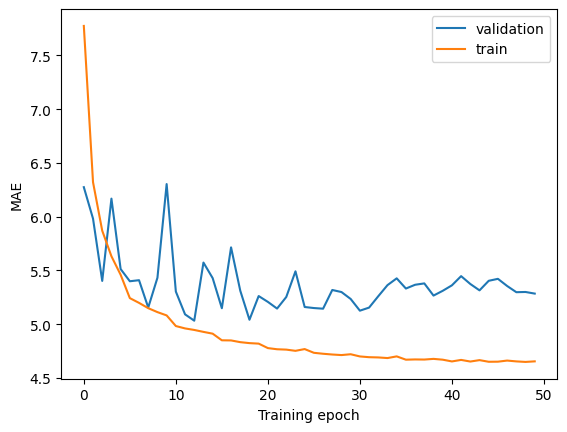

In [13]:
plt.plot(validation_maes, label='validation')
plt.plot(training_maes, label='train')
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("MAE")
#plt.title("MAE vs epochs")
plt.savefig("STGCN_MAE_epoch.png")
plt.show()

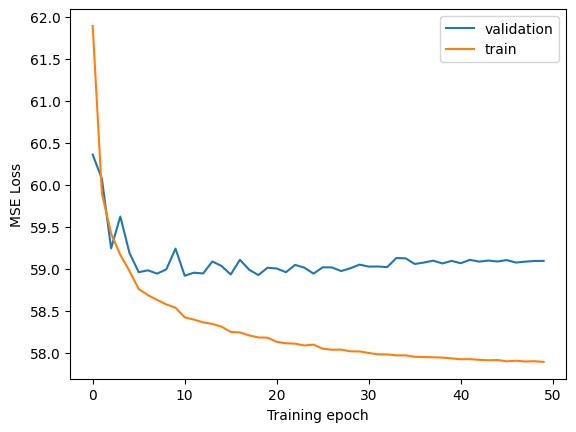

In [14]:
plt.plot(validation_losses, label='validation')
plt.plot(training_losses, label='train')
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("MSE Loss")
#plt.title("Training MSE Loss vs epoch")
plt.savefig("STGCN_MSE_epoch.png")
plt.show()

In [24]:
with torch.no_grad():
    net.eval()
    test_input = X_test.to(device=device)
    test_target = y_test.to(device=device)

    tmp_test_losses = []
    tmp_maes = []
    for i in range(0, test_input.shape[0], batch_size):
        out = net(A, test_input[i:i+batch_size, ...])
        loss = loss_criterion(out, test_target[i:i+batch_size, ...]).to(device="cpu")
        tmp_test_losses.append(np.ndarray.item(loss.detach().numpy())*stds[0]+means[0])
        out_unnormalized = out.detach().cpu().numpy() * stds[0] + means[0]
        target_unnormalized = test_target[i:i+batch_size, ...].detach().cpu().numpy() * stds[0] + means[0]
        mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
        tmp_maes.append(mae)
    test_loss = sum(tmp_test_losses) / len(tmp_test_losses)
    test_mae = sum(tmp_maes) / len(tmp_maes)
    
    out = None
    test_input = test_input.to(device="cpu")
    test_target = test_target.to(device="cpu")

print("Test loss: {}".format(test_loss))
print("Test MAE: {}".format(test_mae))

Test loss: 59.0945762029924
Test MAE: 5.28493347833323


In [17]:
test_input = X_test
test_target = y_test
test_maes = []
# Set the network to evaluation mode
net.eval()

# Create empty lists to store predictions and true labels
predictions = []
true_labels = []

# Loop through the test set and make predictions
with torch.no_grad():
    for i in range(test_input.shape[0]):
        # Get the input and target for this sample
        input_i = test_input[i:i+1, ...].to(device=device)
        target_i = test_target[i:i+1, ...].to(device=device)

        # Make the prediction
        prediction_i = net(A, input_i)
        
        # Convert the prediction and target to numpy arrays and unnormalize them
        prediction_i = prediction_i.detach().cpu().numpy() * stds[0] + means[0]
        target_i = target_i.detach().cpu().numpy() * stds[0] + means[0]
        
        mae = np.mean(np.absolute(prediction_i - target_i))

        # Append the prediction and target to the lists
        predictions.append(prediction_i)
        true_labels.append(target_i)
        test_maes.append(mae)

# Concatenate the lists of predictions and true labels into numpy arrays
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)
test_maes = np.array(test_maes)
worst = np.argmax(test_maes)
best = np.argmin(test_maes)
# plt.plot(predictions[5213,4,:])
# plt.plot(true_labels[5213,4,:])
best, worst

(3674, 3502)

In [18]:
predictions[200,200,:]

array([63.035732, 62.869335, 62.52675 , 62.534096, 62.465675, 62.29469 ,
       62.416893, 62.27143 , 62.224445, 62.348465, 62.436756, 62.194733],
      dtype=float32)

In [19]:
true_labels[200,200,:]

array([64.57143 , 63.22222 , 64.22222 , 61.25    , 64.55556 , 53.166668,
       62.5     , 65.      , 55.285713, 65.      , 68.375   , 63.666668],
      dtype=float32)

In [20]:
true_labels[201,200,:]

array([63.22222 , 64.22222 , 61.25    , 64.55556 , 53.166668, 62.5     ,
       65.      , 55.285713, 65.      , 68.375   , 63.666668, 66.375   ],
      dtype=float32)

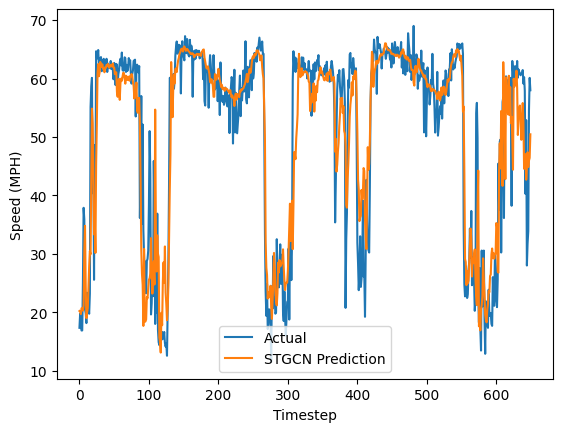

In [25]:
plt.plot(true_labels[2350:3000,100,1], label="Actual")
plt.plot(predictions[2350:3000,100,1], label="STGCN Prediction")
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Speed (MPH)")
#plt.title("True vs Predicted speed")
plt.savefig("STGCN_Prediction.png")
plt.show()

In [26]:
torch.save(net.state_dict(), 'STGCN.pt')